# 3.1 MNIST

- 사이킷런을 이용하여 데이터셋 내려받기

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

In [58]:
# 깔끔한 그래프 출력을 위해
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

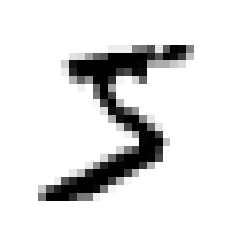

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
import numpy as np

y = y.astype(np.uint8)

- 훈련 세트와 테스트 세트 분리(이미 앞의 60,000개와 뒤의 10,000개로 나위어 있음)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

---

# 3.2 이진 분류기 훈련

- 10 개의 숫자 중 5만 구분할 수 있도록 구현(5와 5가 아닌 숫자, 두 개의 클래스로 분류)

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

- SGDClassifier 클래스를 이용하여 확률적 경사 하강법<sup>Stochastic Gradient Descent</sup>(SGD)분류기 사용
- 매우 큰 데이터셋을 효율적으로 처리하는 장점이 있음

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
# 훈련
sgd_clf.fit(X_train, y_train_5)
# 예측
sgd_clf.predict([some_digit])

array([ True])

---

# 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

- 직접 구현한 교차 검증 기능

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- 사이킷런의 cross_val_score()를 이용한 평가

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 모든 이미지에 대해 5 아닌 숫자에 대한 이진 분류기 만들기

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 정확도를 성능 지표로 삼는 것은 좋지 않다(특히 불균형한 데이터셋에서).

### 3.3.2 오차 행렬

- 분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬<sup>confusion matrix</sup>를 조사하는 것
- cross_val_predict()로 예측을 만든다.
- cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수가 아닌 각 테스트 폴드에서 얻은 예측을 반환한다.
- confusion_matrix() 함수로 오차 행렬 생성
- 오차 행렬의 행은 실제 클래스를, 열은 예측한 클래스를 의미

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

> 5 아님 이미지에 대해 53892 건을 정확하게 분류, 687건을 잘못 분류  
> 5 이미지에 대해 1891 건을 5 아님으로 잘못 분류, 3530건을 5로 정확하게 분류함

In [17]:
# 환벽하게 분류한 경우의 오차 행렬의 형태
y_train_perfect_prediction = y_train_5

confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

> **분류기의 정밀도(양성 예측의 정확도)**  
> $ 정밀도 = \frac{TP}{TP + FP} $  
> TP: 진짜 양성의 수, FP: 거짓 양성의 수

- 정밀도는 재현율<sup>recall</sup>과 함께 사용하는 것이 일반적

> **뷴류기의 재현률(민감도<sup>sensitivity</sup>, 진짜 양성 비율<sup>true positive rate</sup>(TPR))**  
> $ 재현율 = \frac{TP}{TP + FN} $  
> FP: 거짓 음성의 수

| TN(진짜 음성) | FP(거짓 양성) |
|---|---|
| FN(거짓 음성) | TP(진짜 양성) |

### 3.3.3 정밀도와 재현율

- 사이킷런에서 사용되는 함수들

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

> **F<sub>1</sub> 점수<sup>F<sub>1</sub> score</sup>**  
> 정밀도와 재현율의 조화 평균<sup>harmonic mean</sup>  
> $ F_1 = \frac{2}{\frac{1}{정밀도} + \frac{1}{재현율}} = 2 \times \frac{정밀도 \times 재현율}{정밀도 + 재현율} = \frac{TP}{TP + \frac{FN + FP}{2}} $

- f1_score() 함수를 이용하여 F<sub>1</sub> 점수 계산
- 상황에 따라 정밀도와 재현율은 트레이트오프가 있다.

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프

- SGDClassifier는 결정 함수<sup>decision function</sup>를 사용하여 각 샘플의 점수를 계산함며, 점수가 임곗값보다 크면 샘플을 양성 클래스로, 그렇지 않으면 음성 클래스로 할당한다.
- 이 임곗값을 높이면 정밀도는 높아지나 재현율이 낮아지고, 낮추면 정밀도는 낮아지고 재현율이 높아진다.
- 사이킷런에서 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있으며 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.
- 적절한 임곗값을 정하기 위해서는 cross_val_predict() 함수를 사용하여 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.
- precision_recall_curve() 함수를 이용하여 가능한 모든 임곗값에 대한 정밀도와 재현율을 계산할 수 있다.

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
# 임곗값
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
# 결정 젘수를 반환받도록 지정한 코드
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [25]:
# 모든 임곗값에 대한 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


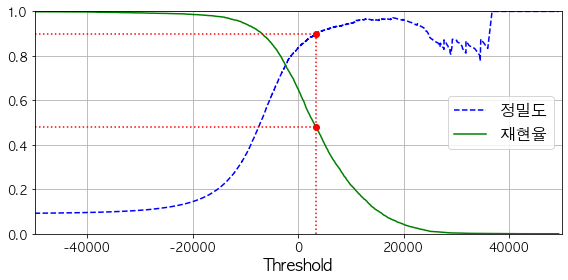

In [26]:
# 임곗값의 함수로 정밀도와 재현율 그리기
import matplotlib

matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = 'AppleGothic'

def plot_precision_recall_vs_threshold(predicions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

그림 저장: precision_vs_recall_plot


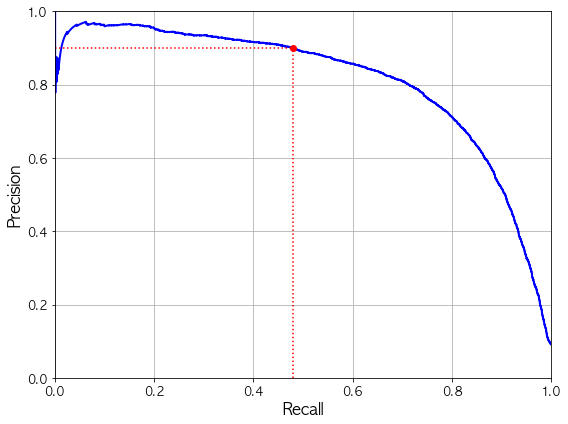

In [27]:
# 재현율에 대한 정밀도 곡선 그리기

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

- 그래프상 재현율 80% 근처에서 정밀도가 급격히 줄어드는데 이 직전 값을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.
- 목표 정밀도를 결정하기 전에 반드시 기준이 되는 최저 재현율을 결정해야 한다.

In [28]:
# 훈련 세트에 대한 예측을 만드는 코드
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
# 위 예측에 대한 정밀도와 재현율
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC(Receiver Operation Characteristic, 수신기 조작 특성) 곡선

- 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율)의 곡선
- ROC 곡선은 민감도(재현율)에 대한 1 - 특이도 그래프(특이도는 진짜 음성 비율<sup>true negative rate</sup>).
- roc_curcve() 함수를 이용해 여러 임곗값에서의 TPR과 FPR을 계산한다.
- TPR과 FPR도 트레이드오프 관계가 있다.

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


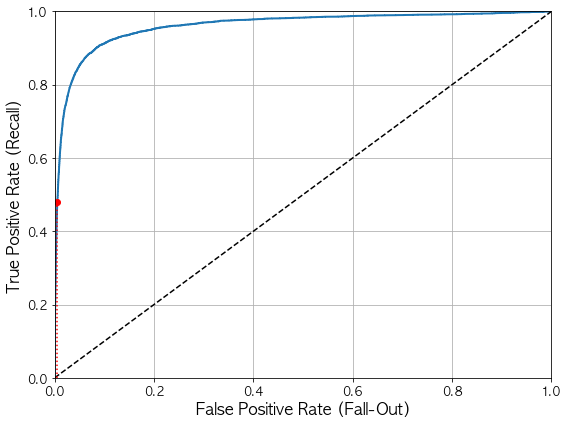

In [32]:
# 그래프 그리기

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

- 곡선 아래 면적<sup>area under the curve<sup>(AUC)를 측정하면 분류기들을 비교할 수 있다.

In [33]:
# ROC의 AUC를 계산
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하고 그렇지 않다면 ROC 곡선을 사용한다. 

In [34]:
# RandomFrestClassifier 모델을 이용한 점수 확인
# predict_proba() 함수는 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [35]:
# roc_curve() 함수는 점수 대신 클래스의 확률을 전달할 수 있다.
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

그림 저장: roc_curve_comparison_plot


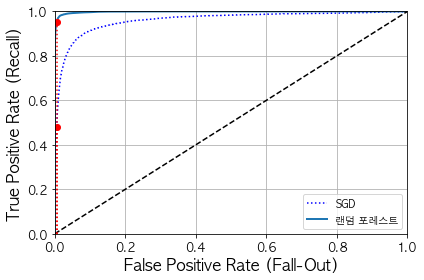

In [36]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right")
save_fig("roc_curve_comparison_plot")
plt.show()

- RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까우므로 SGDClassifier보다 더 좋다.

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

---

# 3.4 다중 분류

- 다중 분류기<sup>multiclass classifier</sup>: 둘 이상의 클래스를 구별할 수 있는 분류기
    - SDG 분류기
    - 랜덤 포레스트 분류기
    - 나이브 베이즈 분류기
    - 이진 분류기를 여러 개 사용하여 다중 클래스 분류
- 이진 분류기를 여러개 사용하여 다중 클래스 분류를 하는 방법
    - OvR<sup>one-versus-the-rest</sup>(OvA<sup>one-versus-all</sup>
        - 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 만들고 각각을 훈련시키고 이미지를 분류할 때 각 분류기의 점수 중 가장 높은 것을 클래스로 선택
    - OvO<sup>one-versus-one</sup>
        - 0과 1, 1과 2, 0과 2 등 각 숫자의 조합마다 이진 분류기를 훈련 시킨 후 가장 많이 양성으로 분류된 클래스를 선택
        - 각 분류기의 훈련에 구별할 두 클래스에 해당하는 샘플만 필요하다는 장점이 있다.
    - 서포트 벡터 머신 같은 일부 알고리즘은 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빨라 OvO를 선호
    - 대부분의 이진 분류 알고리즘에서는 OvR을 선호
    - 다중 분류 작업에 이진 분류기를 선택하면 사이킷런에서 자동으로 OvR 또는 OvO를 선택
    - 명시적으로 OvR이나 OvO를 선택하고자 할 경우 OneVsRestClassifier나 OneVsOneClassifier를 사용

In [38]:
# sklearn.svm.SVC를 이용한 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # 다중 분류이기 때문에 v_train_5가 아닌 y_train 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
# decision_function() 함수를 호출하여 점수 확인
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
# 가장 높은 점수의 클래스 확인
np.argmax(some_digit_scores)

5

In [41]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
svm_clf.classes_[5]

5

In [43]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
# SGDClassifier를 이용한 훈련 (직접 다중 클래스 분류가 가능하므로 OvO, OvR 선택이 필요 없다)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [45]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [46]:
# SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [47]:
# 입력 스케일의 조정을 통한 성능 개선
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

---

# 3.5 에러 분석

- 모델 성능 향상 방법

In [48]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

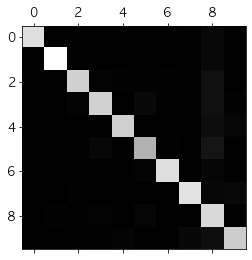

In [49]:
# 어두울수록 데이터셋에 해당 숫자가 적거나 해당 숫자를 잘 분류하지 못한 것
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [50]:
# 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러율을 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

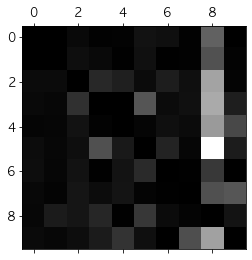

In [51]:
# 주 대각선만 0으로 채워 그래프를 그림
# 행은 실제 클래스, 열은 예측한 클래스를 표시
# 8열이 밝으므로 많은 숫자가 8로 잘못 분류되고 있음을 알 수 있고 3과 5가 많이 혼동된다는 것을 알 수 있음
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 선형 분류기의 경우 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스 점수로 계산하기 때문에 유사한 형태의 숫자를 혼동하기 쉽다.
- 분류기는 이미지의 위치나 회전 방향에 매우 민감하다.

---

# 3.6 다중 레이블 분류

- 다중 레이블 분류<sup>multilabel classification</sup> 시스템: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [52]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [53]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [54]:
# 다중 레이블 분류기에 대한 평가
# 각 레이블에 대한 F1 점수를 구하고 평균을 냄
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- 샘플 수가 많은 데이터셋을 분류한 분류기에 더 높은 점수를 주게 된다.
- 이를 해결하기 위해 레이블에 클래스의 지지도<sup>support</sup>(타깃 레이블에 속한 샘플 수)를 가중치로 준다.
- 이와 같이 하기 위해서는 average="weighted"로 설정한다.

---

# 3.7 다중 출력 분류

- 다중 출력 다중 클래스 분류<sup>multioutput-multiclass classification</sup>(다중 출력 분류<sup>multioutput classification</sup>): 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것(값을 두 개 이상 가질 수 있다).

In [55]:
# 이미지의 잡음을 제거하는 프로그램
# 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 0~255까지 값을 여러 개 가지므로 다중 출력 분류 시스템이다.

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

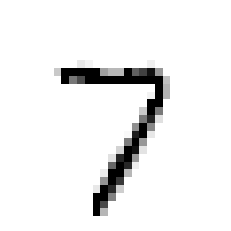

In [59]:
# 분류기 훈련
some_index = 0

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

그림 저장: noisy_digit_example_plot


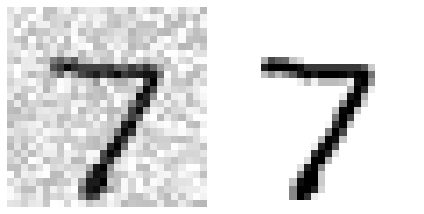

In [60]:
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

- 분류 작업에서 해야 할 일
    - 좋은 측정 지표 선택
    - 적절한 정밀도/재현율 트레이드오프 선택
    - 분류기 비교

---

# 3.8 연습문제

1. MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도 달성하기
    - KNeighborClassifier 사용
    - weight와 n_neighbors에 대해 그리드 탐색을 통해 최적 파라미터 찾기

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

kn_clf = KNeighborsClassifier()

param_grid = [
    {'n_neighbors': [3, 4, 5], 'weights': ["uniform", "distance"]}
]

grid_search = GridSearchCV(kn_clf, param_grid, cv=5, verbose=3)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  10.9s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  10.5s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  10.5s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  10.6s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  11.6s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  10.3s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  10.4s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  10.4s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  10.3s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  10.3s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  10.5s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [65]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights="distance")

knn_clf.fit(X_train, y_train)
knn_clf.predict(X_test)

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)